In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [61]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py'>

In [2]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_output_files/"
output_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/new_result_files/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/annotation_files/"

In [3]:
# load normalized data
pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize.csv"
files = glob.glob(input_path + os.sep + '*' + os.sep + os.sep + '*' + os.sep + pattern, recursive=True)

# TODO: needs to change in the future
# TODO: process only what is not processed yet
Data = []

for file in files:
    
    filename = os.path.basename(file)
    
    try:
        
        Data_Temp = pd.read_csv(file)
        row_count = Data_Temp.shape[0]
        
        print(f"File: {filename} has {row_count} rows")
        
        Data.append(Data_Temp)
            
    except Exception as e:
        
        print(f"Error reading file {filename}: {e}")
        
        
### concat all files together
Data_aggregated = pd.concat(Data)
Data_aggregated = Data_aggregated.reset_index(drop = True)

print("Aggregated Data has shape ", Data_aggregated.shape)

File: C1231_R1_mad_robustize.csv has 384 rows
File: C1241_R1_mad_robustize.csv has 384 rows
File: C1230_R3_mad_robustize.csv has 384 rows
File: C1230_R4_mad_robustize.csv has 384 rows
File: C1231_R4_mad_robustize.csv has 384 rows
File: C1241_R2_mad_robustize.csv has 384 rows
File: C1230_R2_mad_robustize.csv has 384 rows
File: C1231_R2_mad_robustize.csv has 384 rows
File: C1241_R3_mad_robustize.csv has 384 rows
File: C1230_R1_mad_robustize.csv has 384 rows
File: C1231_R3_mad_robustize.csv has 384 rows
File: C1162_R4_mad_robustize.csv has 384 rows
File: C1175_R1_mad_robustize.csv has 384 rows
File: C1160_R2_mad_robustize.csv has 384 rows
File: C1160_R3_mad_robustize.csv has 384 rows
File: C1165_R2_mad_robustize.csv has 384 rows
File: C1176_R1_mad_robustize.csv has 384 rows
File: C1167_R1_mad_robustize.csv has 384 rows
File: C1166_R1_mad_robustize.csv has 384 rows
File: C1158_R4_mad_robustize.csv has 384 rows
File: C1158_R2_mad_robustize.csv has 384 rows
File: C1170_R1_mad_robustize.csv h

In [59]:
replicate_list = Data_aggregated['Metadata_plate_map_name'].unique()
replicate_dataframe = pd.DataFrame(replicate_list, columns=['Metadata_plate_map_name']) 

replicate_list_newcolumns = replicate_dataframe['Metadata_plate_map_name'].str.split('_', n=1, expand=True)
replicate_dataframe['Metadata_plate_name'] = replicate_list_newcolumns[0]
replicate_dataframe['Metadata_replicate_number'] = replicate_list_newcolumns[1]

replicate_counts = replicate_dataframe.groupby('Metadata_plate_name')['Metadata_replicate_number'].count().reset_index()

# Group by 'measurement_code' and filter groups that have exactly four replicates
filtered_replicate_dataframe= replicate_dataframe.groupby('Metadata_plate_name').filter(lambda x: len(x['Metadata_replicate_number']) == 4)
filtered_replicate_dataframe = filtered_replicate_dataframe.sort_values(by=['Metadata_plate_name'])

Data_aggregated_filtered = Data_aggregated[Data_aggregated['Metadata_plate_map_name'].isin(filtered_replicate_dataframe['Metadata_plate_map_name'])]

In [77]:
Data_aggregated_filtered_source = Data_aggregated_filtered.loc[Data_aggregated_filtered['Metadata_source'] == 'USC'].reset_index()

Data_aggregated_filtered_source_plate = Data_aggregated_filtered_source.loc[Data_aggregated_filtered_source['Metadata_plate_name'] == 'C1162'].reset_index()

In [79]:
# Fature reduction
# Test show reproducibility significantly lower with full feature set!
# Thus we need some way to reduce the feature set
# But we also know that the below method produces a variable feature set
# So maybe need to rethink the method
print("Feature reduction with correlation threshold 0.9 and Outlier threshold 100")
filtered_source_plate_feature_select = CBE.feature_reduction(Data_aggregated_filtered_source_plate, 
                                         variance_freq_cut=0.1, 
                                         variance_unique_cut=0.1, 
                                         outlier_cutoff=100, 
                                         corr_threshold = 0.9, 
                                         print_stats = True)

Feature reduction with correlation threshold 0.9 and Outlier threshold 100
| Category           |   Original Features |   Variance Threshold |   % Variance |   Outlier Threshold |   % Outlier |   Correlation Threshold |   % Correlation |
|:-------------------|--------------------:|---------------------:|-------------:|--------------------:|------------:|------------------------:|----------------:|
| Total Features     |                2977 |                 2822 |         94.8 |                2810 |        94.4 |                     498 |            16.7 |
| Intensity          |                 180 |                  180 |        100   |                 180 |       100   |                      19 |            10.6 |
| Correlation        |                 180 |                  127 |         70.6 |                 121 |        67.2 |                      68 |            37.8 |
| AreaShape          |                 162 |                  153 |         94.4 |                 153 |      

In [92]:
# get unique Metadata_RoughID
def merge_if_eos_cpd(row):

    if row['Metadata_RoughID'] == 'EOS_cpd':

        return f"{row['Metadata_Well']}_{row['Metadata_RoughID']}"
    
    else:

        return row['Metadata_RoughID']
    

filtered_source_plate_feature_select['Metadata_RoughID_unique'] = filtered_source_plate_feature_select.apply(merge_if_eos_cpd, axis=1)

filtered_source_plate_feature_select.head()

,level_0,index,Metadata_Well,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,Metadata_plate_name,...,Cyto_Texture_Correlation_Mito_10_03_256,Cyto_Texture_InfoMeas1_AGP_3_00_256,Cyto_Texture_InfoMeas1_AGP_5_03_256,Cyto_Texture_InfoMeas1_DNA_10_02_256,Cyto_Texture_InfoMeas1_DNA_3_01_256,Cyto_Texture_InfoMeas1_ER_10_03_256,Cyto_Texture_InfoMeas1_Mito_3_00_256,Cyto_Texture_InfoMeas2_ER_10_03_256,Cyto_Texture_SumAverage_ER_5_02_256,Metadata_RoughID_unique
0,0,4224,M03,Sonata,19:29:02,USC,200,HepG2_10uM,A01,C1162,...,0.221583,2.187932,4.372588,1.363633,3.106717,-0.302066,0.071098,0.403125,-0.120517,M03_EOS_cpd
1,1,4225,C23,Sonata,19:29:02,USC,200,HepG2_10uM,A02,C1162,...,-1.226965,0.000157,0.085137,0.115132,-0.628421,-0.464208,1.123809,0.349549,0.541744,DMSO
2,2,4226,O10,Sonata,19:29:02,USC,200,HepG2_10uM,A03,C1162,...,1.585765,1.026100,2.159473,1.063700,1.659476,1.315095,1.155524,-1.434217,-2.001521,O10_EOS_cpd
3,3,4227,K04,Sonata,19:29:02,USC,200,HepG2_10uM,A04,C1162,...,-0.815843,-0.804621,-1.954052,-1.834921,-2.281287,0.449196,1.399768,-1.405628,-0.093266,K04_EOS_cpd
4,4,4228,H05,Sonata,19:29:02,USC,200,HepG2_10uM,A05,C1162,...,-0.726229,0.767934,1.753754,1.561700,2.544197,-0.002278,0.673807,-0.076514,-1.062845,H05_EOS_cpd



# Compute toxicity

In [93]:
def pad_numbers(value):
    match = re.match(r"([A-Z])(\d+)", value)
    if match:
        letter = match.group(1)
        number = match.group(2).zfill(2)  # Pad number to 2 digits
        return f"{letter}{number}"
    return value

In [94]:
# per source and plate, plot over imaging time
# tally up also

# Missing wells need to be included
# Compounds with not all replicates also important information
# TODO: Compute missing wells
# get info for pos. and neg. controls
controls_layout_path = os.path.join(annotation_dir, "pos_neg_ctrl.csv")

try:
                
    controls_layout = pd.read_csv(controls_layout_path)
                
    # Issue in the plate layout the well numbers are not padded
    controls_layout['Metadata_Well'] = controls_layout['Metadata_Well'].apply(pad_numbers)
            
except Exception as e:
                
    print(f"Error reading {controls_layout}: {str(e)}")


controls_layout['Metadata_RoughID_unique'] = controls_layout.apply(merge_if_eos_cpd, axis=1)

,Metadata_Well,Metadata_RoughID,Metadata_RoughID_unique
0,A01,EOS_cpd,A01_EOS_cpd
1,B01,EOS_cpd,B01_EOS_cpd
2,C01,EOS_cpd,C01_EOS_cpd
3,D01,EOS_cpd,D01_EOS_cpd
4,E01,EOS_cpd,E01_EOS_cpd


# Missing compounds

In [97]:
all_ID = controls_layout['Metadata_RoughID_unique'].unique()
plate_ID = filtered_source_plate_feature_select['Metadata_RoughID_unique'].unique()
print("HepG2: There are ",len(all_ID) - len(plate_ID),"compounds missing")

HepG2: There are  0 compounds missing


# Compounds with less than 4 replicates

In [99]:
filtered_source_plate_feature_select_replicates = filtered_source_plate_feature_select['Metadata_RoughID_unique'].value_counts()
print("HepG2: There are",len(filtered_source_plate_feature_select_replicates[filtered_source_plate_feature_select_replicates.iloc[:] < 4]), "compounds with less than 4 replicates.")

HepG2: There are 0 compounds with less than 4 replicates.


# Cell numbers

(0.0, 700.0)

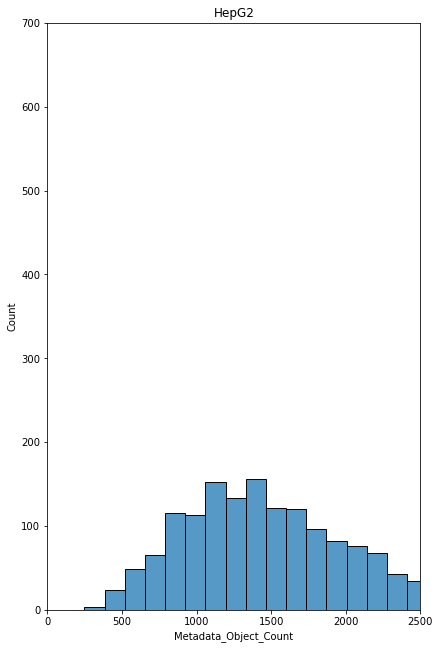

In [101]:
plt.rcParams["figure.figsize"] = (7,10)

fig, (ax1)= plt.subplots(1, sharex=True, sharey=True)
ax1.title.set_text('HepG2')
fig.tight_layout(pad=5.0)
sns.histplot(data=filtered_source_plate_feature_select, x="Metadata_Object_Count", ax = ax1)
plt.xlim([0, 2500])
plt.ylim([0, 700])

# plt.savefig(figure_path + str(date.today()) + '_CellNumber.pdf',  dpi=300)

In [102]:
# plot cell numbers of controls
filtered_source_plate_feature_select_controls = filtered_source_plate_feature_select[(filtered_source_plate_feature_select["Metadata_RoughID_unique"] == "DMSO") |
                                    (filtered_source_plate_feature_select["Metadata_RoughID_unique"] == "Nocodazole") |
                                    (filtered_source_plate_feature_select["Metadata_RoughID_unique"] == "Tetrandrine") ]

<AxesSubplot: title={'center': 'HepG2'}, xlabel='Metadata_RoughID_unique', ylabel='Metadata_Object_Count'>

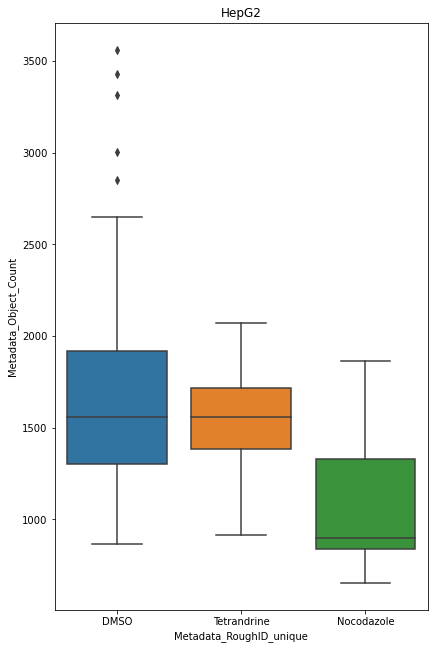

In [104]:
fig, (ax1)= plt.subplots(1, sharex=False, sharey=True)
ax1.title.set_text('HepG2')
fig.tight_layout(pad=5.0)
sns.boxplot(data=filtered_source_plate_feature_select_controls, y="Metadata_Object_Count", x="Metadata_RoughID_unique", ax=ax1)

# plt.savefig(figure_path + str(date.today()) + '_CellNumberControls.pdf',  dpi=300)

# Compute consensus

# Toxicity

In [ ]:
missing_compounds = pd.merge(controls_layout, 
                                 filtered_source_plate_feature_select,
                                 on = ["Metadata_RoughID_unique"],
                                 how = "left",
                                 indicator = True)

missing_compounds = missing_compounds[missing_compounds["_merge"] == 'left_only'].dropna(axis='columns')

In [121]:
missing_compounds.head()

,Metadata_Well_x,Metadata_RoughID_x,Metadata_RoughID_unique,level_0,index,Metadata_Well_y,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,...,Cyto_Texture_Correlation_Mito_10_03_256,Cyto_Texture_InfoMeas1_AGP_3_00_256,Cyto_Texture_InfoMeas1_AGP_5_03_256,Cyto_Texture_InfoMeas1_DNA_10_02_256,Cyto_Texture_InfoMeas1_DNA_3_01_256,Cyto_Texture_InfoMeas1_ER_10_03_256,Cyto_Texture_InfoMeas1_Mito_3_00_256,Cyto_Texture_InfoMeas2_ER_10_03_256,Cyto_Texture_SumAverage_ER_5_02_256,_merge


In [122]:
## 2.5 Std from population median
# TODO: problematic tox threshold does not work currently
# Now set to 1.5 STDs from sample median
# Works well on larger samples...???
SD_Threshold = 1.5

tox_threshold_1 = filtered_source_plate_feature_select["Metadata_Object_Count"].median() - (SD_Threshold * filtered_source_plate_feature_select["Metadata_Object_Count"].std())
print("Tox threshold:", tox_threshold_1)

FMP_Toxic_conditions_1 = filtered_source_plate_feature_select.loc[filtered_source_plate_feature_select["Metadata_Object_Count"] < tox_threshold_1]
print("Toxic conditions: " + str(len(FMP_Toxic_conditions_1 )) + " compounds (" + str(SD_Threshold) + " Std from population median)")

Tox threshold: 513.6489880532356
Toxic conditions: 27 compounds (1.5 Std from population median)


# Compute induction 

In [ ]:
# based on consensus profiles
# In the original analysis this is done after removing toxic compounds
# per source and plate, plot over imaging time
# tally up also

# Compute metrics over replicates

In [ ]:
# % replication over plates per source, per plate, plot over imaging time

In [62]:
Data_aggregated_filtered.head()

,Metadata_Well,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,Metadata_plate_name,Metadata_Plate,Metadata_RoughID,...,Cyto_Texture_Variance_Mito_10_02_256,Cyto_Texture_Variance_Mito_10_03_256,Cyto_Texture_Variance_Mito_3_00_256,Cyto_Texture_Variance_Mito_3_01_256,Cyto_Texture_Variance_Mito_3_02_256,Cyto_Texture_Variance_Mito_3_03_256,Cyto_Texture_Variance_Mito_5_00_256,Cyto_Texture_Variance_Mito_5_01_256,Cyto_Texture_Variance_Mito_5_02_256,Cyto_Texture_Variance_Mito_5_03_256
0,O02,CV8000,12:02:30,IMTM,200,HepG2_10uM,A01,C1231,C1231R1,EOS_cpd,...,-0.388569,-0.397480,-0.337381,-0.377193,-0.220344,-0.300281,-0.445350,-0.339305,-0.324083,-0.251298
1,K17,CV8000,12:02:30,IMTM,200,HepG2_10uM,A02,C1231,C1231R1,EOS_cpd,...,-1.846548,-1.797749,-1.870155,-2.100688,-1.731961,-1.689617,-1.989911,-1.850223,-1.785348,-1.653460
2,I19,CV8000,12:02:30,IMTM,200,HepG2_10uM,A03,C1231,C1231R1,EOS_cpd,...,-1.222520,-1.225155,-1.187286,-1.342566,-1.066288,-1.090041,-1.269058,-1.270187,-1.118566,-1.117101
3,B09,CV8000,12:02:30,IMTM,200,HepG2_10uM,A04,C1231,C1231R1,EOS_cpd,...,-1.274747,-1.309010,-1.318618,-1.404711,-1.210333,-1.170232,-1.347972,-1.327596,-1.237409,-1.137469
4,N10,CV8000,12:02:30,IMTM,200,HepG2_10uM,A05,C1231,C1231R1,EOS_cpd,...,-0.256909,-0.259292,-0.174461,-0.214816,-0.241352,-0.162724,-0.293659,-0.256376,-0.244783,-0.154303


In [ ]:
source_list = Data_aggregated_filtered['Metadata_source'].unique()

In [69]:
Data_aggregated_filtered_source_plate.head()

,level_0,index,Metadata_Well,Metadata_instrument,Metadata_imaging_time,Metadata_source,Metadata_imaging_timezone,Metadata_Batch,Metadata_Well_randomized,Metadata_plate_name,...,Cyto_Texture_Variance_Mito_10_02_256,Cyto_Texture_Variance_Mito_10_03_256,Cyto_Texture_Variance_Mito_3_00_256,Cyto_Texture_Variance_Mito_3_01_256,Cyto_Texture_Variance_Mito_3_02_256,Cyto_Texture_Variance_Mito_3_03_256,Cyto_Texture_Variance_Mito_5_00_256,Cyto_Texture_Variance_Mito_5_01_256,Cyto_Texture_Variance_Mito_5_02_256,Cyto_Texture_Variance_Mito_5_03_256
0,0,4224,M03,Sonata,19:29:02,USC,200,HepG2_10uM,A01,C1162,...,9.739899,10.234126,9.756981,10.172532,9.681185,9.918125,9.515439,10.391508,10.300715,10.294461
1,1,4225,C23,Sonata,19:29:02,USC,200,HepG2_10uM,A02,C1162,...,0.299555,0.399010,0.290038,0.238816,0.265432,0.364529,0.263534,0.235307,0.297867,0.383976
2,2,4226,O10,Sonata,19:29:02,USC,200,HepG2_10uM,A03,C1162,...,0.099154,0.210273,0.100786,0.184939,0.098823,0.240734,0.130820,0.217089,0.193355,0.176364
3,3,4227,K04,Sonata,19:29:02,USC,200,HepG2_10uM,A04,C1162,...,-0.980170,-0.953509,-0.906540,-0.919822,-0.911726,-0.925222,-0.936046,-0.938890,-0.947132,-0.919098
4,4,4228,H05,Sonata,19:29:02,USC,200,HepG2_10uM,A05,C1162,...,1.780246,1.753571,1.628963,1.641279,1.637672,1.650305,1.682392,1.736021,1.659129,1.707860


In [ ]:
# problem: need consistent ID over replicates Metadata_RoughID is insufficient
# could produce this from the wellID Metadata_Well
# But this needs to be solved differently in the future

In [74]:
replicating_source_plate, corr_replicating_source_plate = CBE.remove_non_reproducible(
    HepG2_Reduced_Carsten_100_Mod, 
    n_samples = 10000, 
    n_replicates = 4, 
    ID_col = "Metadata_Well", 
    description = "USC C1162")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| USC C1162     |                  28.4 |
Nonreplicating conditions removed with threshold 0.26
Old shape (1536, 516)
New shape (436, 516)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis/notebooks/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


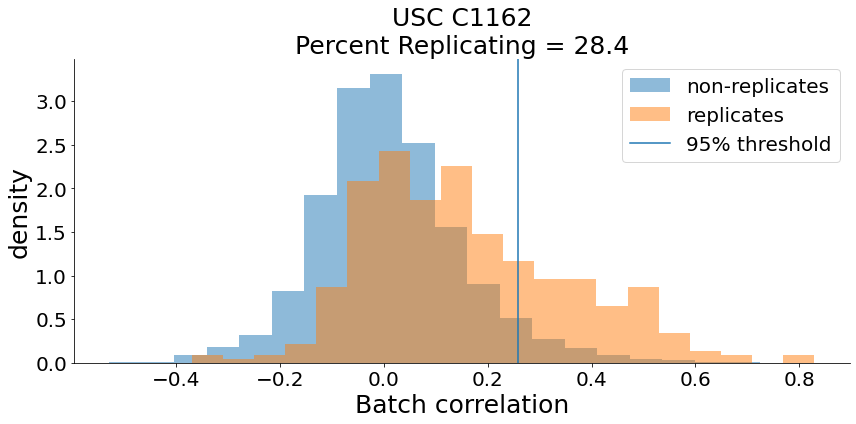

In [75]:
n_experiments = len(corr_replicating_source_plate)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_source_plate.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_source_plate.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_source_plate.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_source_plate.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_source_plate.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()

plt.tight_layout()

# plt.savefig(figure_path + str(date.today()) + "_HepG2_Percent_Replicating.pdf", 
#            transparent=False, 
#            bbox_inches='tight', 
#            dpi = 600)

In [ ]:
# TODO: If all replicates exist:
# TODO: Feature reduction per plate
# TODO: Compute number of toxic compounds
# TODO: Compute raw % replication
# TODO: Compute compound activity based on DMSO
# TODO: Compute % replication after compound filters